In [29]:
import numpy as np
import matplotlib.pyplot as plt
import math

import scipy.sparse as sps
from scipy.ndimage import gaussian_filter
from scipy.sparse.linalg import LinearOperator
from scipy.sparse.linalg import cg as scipy_cg
from scipy.sparse.linalg import aslinearoperator

from scipy.optimize import minimize

from gpcg import GPCGSolver
from gpcg import make_1d_signal, make_shepp_logan_image, build_1d_first_order_grad, build_2d_first_order_grad

# Problem setup

In [30]:
# Parameters for the problem
n = 100
reg_lambda = 1e2
blur_sigma = 1.5
noise_sigma = 0.2

# Make test signal
dom = np.linspace(0, 1, 100)
x = make_1d_signal( dom ) + np.sin(5*dom)

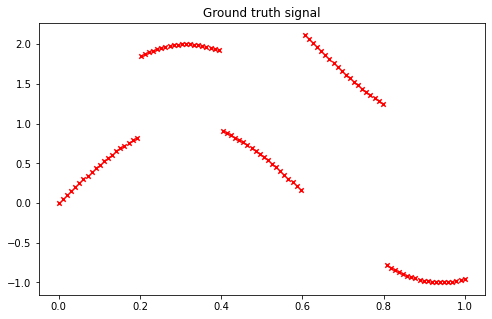

In [31]:
plt.figure(figsize=(8,5))
plt.scatter(dom, x, marker="x", color="red", s=20.0)
plt.title("Ground truth signal")
plt.show()

In [32]:
# Setup measurement and regularization operators
_matvec = lambda x: gaussian_filter(x, sigma=float(blur_sigma), mode="wrap")
F = LinearOperator((n,n), matvec=_matvec, rmatvec=_matvec)

# Build \lambda R operator
rmat = build_1d_first_order_grad(n, boundary="zero")
R = aslinearoperator(rmat)

# Build Q operator (plays role of A)
Q = (1.0/(noise_sigma**2))*(F.T @ F) + reg_lambda*(R.T @ R)

In [33]:
# Create some artificial data
np.random.seed(0)
y = F.matvec(x) + noise_sigma*np.random.randn(n)

# Get solution via standard cg
scipy_cg_sol, _ = scipy_cg(Q, (1.0/(noise_sigma**2))*F.rmatvec(y) , maxiter=1e5)

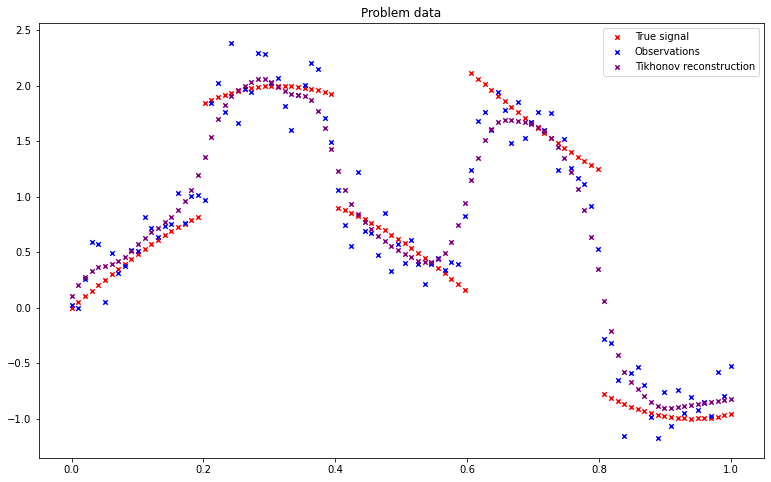

In [34]:
plt.figure(figsize=(13,8))
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.scatter(dom, scipy_cg_sol, marker="x", color="purple", s=20.0, label="Tikhonov reconstruction")
plt.legend()
plt.title("Problem data")
plt.show()

# L curve

In [35]:
from regtoolkit.cg import relative_residual_cg

In [36]:
# L curve parameters
lambda_min = 1e-5
lambda_max = 1e1
n_lambdas = 100
cg_eps = 1e-3
cg_maxits = 1000

# Setup
lambdas = np.logspace(np.log(lambda_min), np.log(lambda_max), num=n_lambdas)
x_tikh = None
fidelity_terms = []
reg_terms = []

for lam in lambdas:

    # Make mat
    Q = (F.T @ F) + lam*(R.T @ R)

    # Get the Tikhonov solution for the current value of lambda
    sol = relative_residual_cg(Q, F.T @ y, eps=cg_eps, maxits=cg_maxits, x0=x_tikh)
    x_tikh = sol["x"]

    # Compute norms
    fidelity_term = np.linalg.norm(F @ x_tikh - y, ord=2)
    reg_term = np.linalg.norm(R @ x_tikh, ord=2)
    fidelity_terms.append(fidelity_term)
    reg_terms.append(reg_term)

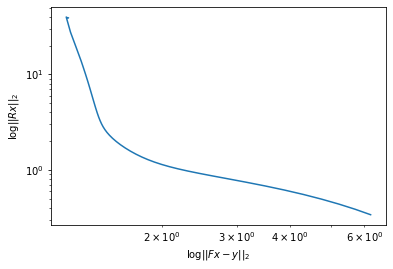

In [37]:
plt.loglog(fidelity_terms, reg_terms)
plt.xlabel(r"$\log || F x - y ||_2$")
plt.ylabel(r"$\log || R x ||_2$")
plt.show()

In [38]:
def lcurve(F, R, y, lambda_min=1e-7, lambda_max=1e4, n_lambdas=200, cg_tol=1e-7, cg_maxits=1000):
    """Computes points on the L-curve corresponding to Tikhonov regularization. Here
            x_{\lambda} = \argmin_{x} \| F x -y \|_2^2 + \lambda \| R x \|_2^2,
            data_fidelity = \| F x_{\lambda} - y \|_2^2 
            reg_term = \| R x_{\lambda} \|_2^2
    and we output a dict of these terms, as well as the lambda values.
    """

    # Setup
    lambdas = np.logspace(np.log(lambda_min), np.log(lambda_max), num=n_lambdas)
    x_tikh = None
    fidelity_terms = []
    reg_terms = []
    x_tikhs = []
    
    # Compute terms
    for lam in lambdas:

        # Make mat
        Q = (F.T @ F) + lam*(R.T @ R)

        # Get the Tikhonov solution for the current value of lambda
        sol = relative_residual_cg(Q, F.T @ y, eps=cg_tol, maxits=cg_maxits, x0=x_tikh)
        x_tikh = sol["x"]

        # Compute norms
        fidelity_term = np.linalg.norm(F @ x_tikh - y, ord=2)
        reg_term = np.linalg.norm(R @ x_tikh, ord=2)
        fidelity_terms.append(fidelity_term)
        reg_terms.append(reg_term)
        x_tikhs.append(x_tikh)

    data = {
        "lambdas": lambdas,
        "x_lambdas": x_tikhs,
        "data_terms": np.asarray(fidelity_terms),
        "reg_terms": np.asarray(reg_terms),
    }

    return data

In [39]:
data = lcurve(F, R, y)

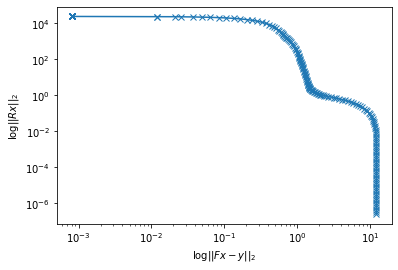

In [40]:
plt.loglog(data["data_terms"], data["reg_terms"], marker="x")
plt.xlabel(r"$\log || F x - y ||_2$")
plt.ylabel(r"$\log || R x ||_2$")
plt.show()

# Spline to find point of max curvature

In [41]:
from scipy.interpolate import splev
from scipy.interpolate import splrep, BSpline

In [42]:
# Get data
data_terms = data["data_terms"]
reg_terms = data["reg_terms"]
lambdas = data["lambdas"]
x_lambdas = data["x_lambdas"]

# Reorder so that increasing in data_terms
inds = data_terms.argsort()
data_terms = data_terms[inds]
reg_terms = reg_terms[inds]
lambdas = lambdas[inds]

# Make spline
tck = splrep( np.log(data_terms), np.log(reg_terms), s=5)

# Grid to evaluate curvatures on
dom = np.linspace( np.log(np.amin(data_terms)), np.log(np.amax(data_terms)), num=500  )

# Compute first and second derivatives
first_derivs = splev(dom, tck, der=1)
second_derivs = splev(dom, tck, der=2)
curvatures = np.abs(second_derivs)/( (1 + (first_derivs**2) )**(1.5) )

# Get index of max curvature
max_curve_idx = np.argmax(curvatures)

# Find closest data_term coord to point of max curvature
max_curve_data_term = dom[max_curve_idx]
closest_data_term_idx = np.abs(np.log(data_terms) - max_curve_data_term).argmin() 

# Return the lambda corresponding to this value
max_curvature_lambda_est = lambdas[closest_data_term_idx]
max_curvature_x_lambda = x_lambdas[closest_data_term_idx]

In [43]:
print(max_curvature_lambda_est)

0.4617930564051554


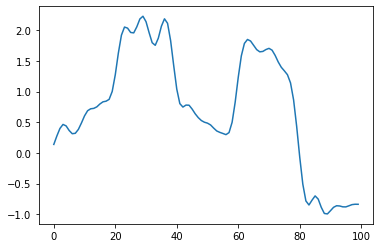

In [44]:
plt.plot(max_curvature_x_lambda)
plt.show()

In [45]:
def compute_lcurve_corner(lcurve_data):
    """Assuming the L curve actually has a corner, produces an estimate of the corner. Accepts
    output of lcurve as input."""
    
    # Get data
    data_terms = lcurve_data["data_terms"]
    reg_terms = lcurve_data["reg_terms"]
    lambdas = lcurve_data["lambdas"]
    x_lambdas = lcurve_data["x_lambdas"]

    # Reorder so that increasing in data_terms
    inds = data_terms.argsort()
    data_terms = data_terms[inds]
    reg_terms = reg_terms[inds]
    lambdas = lambdas[inds]

    # Make spline
    tck = splrep( np.log(data_terms), np.log(reg_terms), s=5)

    # Grid to evaluate curvatures on
    dom = np.linspace( np.log(np.amin(data_terms)), np.log(np.amax(data_terms)), num=500  )

    # Compute first and second derivatives
    first_derivs = splev(dom, tck, der=1)
    second_derivs = splev(dom, tck, der=2)
    curvatures = np.abs(second_derivs)/( (1 + (first_derivs**2) )**(1.5) )

    # Get index of max curvature
    max_curve_idx = np.argmax(curvatures)

    # Find closest data_term coord to point of max curvature
    max_curve_data_term = dom[max_curve_idx]
    closest_data_term_idx = np.abs(np.log(data_terms) - max_curve_data_term).argmin() 

    # Return the lambda corresponding to this value
    max_curvature_lambda_est = lambdas[closest_data_term_idx]
    max_curvature_x_lambda = x_lambdas[closest_data_term_idx]
    max_curvature_data_term = data_terms[closest_data_term_idx]
    max_curvature_reg_term = reg_terms[closest_data_term_idx]

    # Package output
    data = {
        "lambda": max_curvature_lambda_est,
        "x_lambda": max_curvature_x_lambda,
        "data_term": max_curvature_data_term,
        "reg_term": max_curvature_reg_term
    }

    return data




In [46]:
ldata = compute_lcurve_corner(data)

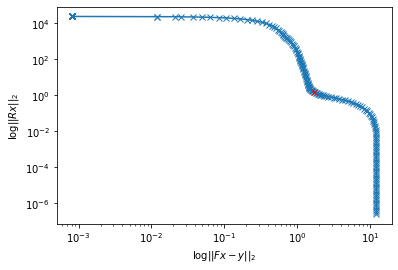

In [47]:
plt.loglog(data["data_terms"], data["reg_terms"], marker="x")
plt.loglog(ldata["data_term"], ldata["reg_term"], marker="x", color="red")
plt.xlabel(r"$\log || F x - y ||_2$")
plt.ylabel(r"$\log || R x ||_2$")
plt.show()

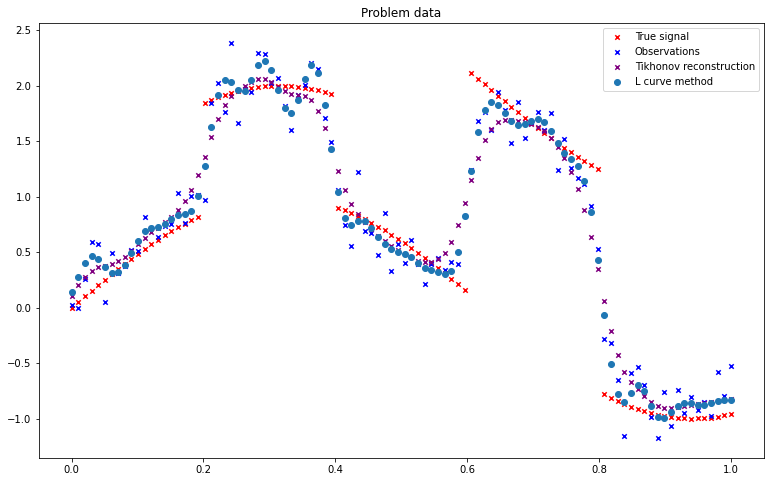

In [48]:
plt.figure(figsize=(13,8))
dom = np.linspace(0, 1, 100)
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.scatter(dom, scipy_cg_sol, marker="x", color="purple", s=20.0, label="Tikhonov reconstruction")
plt.scatter(dom, ldata["x_lambda"], label="L curve method")
plt.legend()
plt.title("Problem data")
plt.show()

# Same problem, but with R = I?

In [24]:
R = aslinearoperator(sps.eye(n))

In [25]:
data = lcurve(F, R, y)

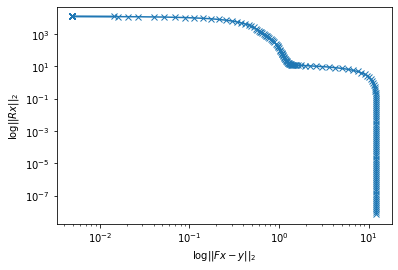

In [26]:
plt.loglog(data["data_terms"], data["reg_terms"], marker="x")
plt.xlabel(r"$\log || F x - y ||_2$")
plt.ylabel(r"$\log || R x ||_2$")
plt.show()

In [27]:
ldata = compute_lcurve_corner(data)

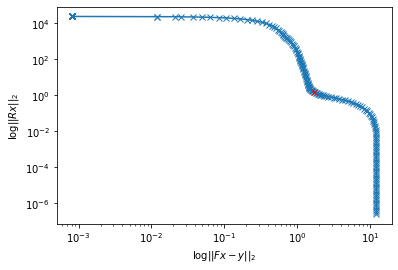

In [56]:
plt.loglog(data["data_terms"], data["reg_terms"], marker="x")
plt.loglog(ldata["data_term"], ldata["reg_term"], marker="x", color="red")
plt.xlabel(r"$\log || F x - y ||_2$")
plt.ylabel(r"$\log || R x ||_2$")
plt.show()

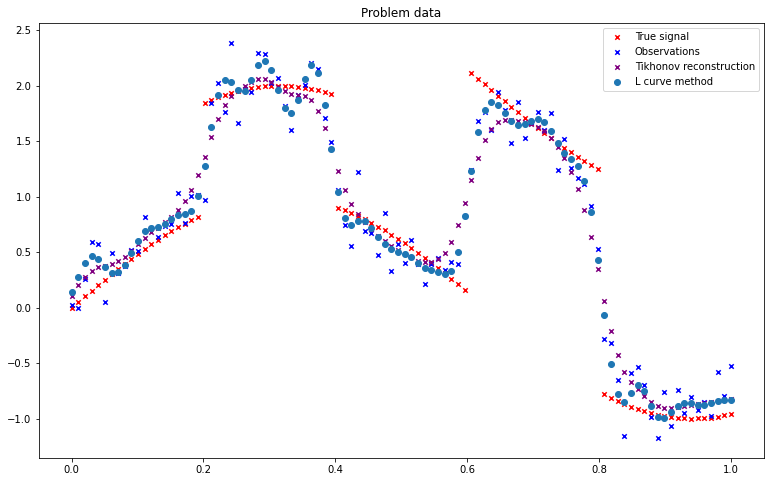

In [57]:
plt.figure(figsize=(13,8))
dom = np.linspace(0, 1, 100)
plt.scatter(dom, x, marker="x", color="red", s=20.0, label="True signal")
plt.scatter(dom, y, marker="x", color="blue", s=20.0, label="Observations")
plt.scatter(dom, scipy_cg_sol, marker="x", color="purple", s=20.0, label="Tikhonov reconstruction")
plt.scatter(dom, ldata["x_lambda"], label="L curve method")
plt.legend()
plt.title("Problem data")
plt.show()